# Module 1 - Graph basics: Queries, Algorithms & Vectors  

This module has the following objectives:
- Creating a Graph from Structured Data
- Basic Cypher Queries and Pattern Matching
- Graph Algorithms
- Text Embeddings for Semantic Analysis
- Vector Search

In [1]:
!pip install graphdatascience neo4j dotenv langchain langchain_openai

Import our usual suspects (and some more...)

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv
from graphdatascience import GraphDataScience
from neo4j import Query, GraphDatabase, RoutingControl, Result
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import matplotlib.pyplot as plt
import seaborn as sns

## Setup

Load env variables

In [3]:
env_file = 'ws.env'

In [4]:
if os.path.exists(env_file):
    load_dotenv(env_file, override=True)

    # Neo4j
    HOST = os.getenv('NEO4J_URI')
    USERNAME = os.getenv('NEO4J_USERNAME')
    PASSWORD = os.getenv('NEO4J_PASSWORD')
    DATABASE = os.getenv('NEO4J_DATABASE')

    # AI
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
    os.environ['OPENAI_API_KEY']=OPENAI_API_KEY
    LLM = os.getenv('LLM')
else:
    print(f"File {env_file} not found.")

## Read Data

Load synthetic Skills dataset

In [5]:
url = "https://github.com/erikbijl/genai-workshop-amsterdam/raw/refs/heads/main/talent/data/expanded_skills.csv"

In [6]:
skills_df = pd.read_csv(url)

Describe the dataset

In [7]:
skills_df.describe()

,email,name,skills
count,100,100,100
unique,100,100,100
top,thomas.nelson@test.org,Thomas Nelson,"Security, Pandas, Go"
freq,1,1,1


Display the first few rows of the DataFrame

In [8]:
skills_df.head(10)

,email,name,skills
0,thomas.nelson@test.org,Thomas Nelson,"Security, Pandas, Go"
1,lucy.clark@test.org,Lucy Clark,"WordPress, Scrum, Go, SQL, Linux"
2,richard.jackson@test.org,Richard Jackson,"System Design, PyTorch, Express.js, DevOps"
3,amelia.hall@test.org,Amelia Hall,"Agile, CSS3, R, Azure"
4,david.hill@test.org,David Hill,"Java, Scrum, Angular"
5,christopher.johnson@test.org,Christopher Johnson,"Tableau, Flask, API Design"
6,amelia.martin@test.org,Amelia Martin,"CI/CD, Kotlin, HTML5, TensorFlow"
7,daniel.hill@test.org,Daniel Hill,"System Design, Git, Cypher, Pandas, Spring Boot"
8,alice.white@test.org,Alice White,"Spark, Agile, JavaScript"
9,lucy.taylor@test.org,Lucy Taylor,"Flask, Tableau, CI/CD, Rust, System Design"


Convert skills column from comma separated string to List

In [9]:
skills_df['skills'] = skills_df['skills'].str.split(', ')
skills_df.head()

,email,name,skills
0,thomas.nelson@test.org,Thomas Nelson,"[Security, Pandas, Go]"
1,lucy.clark@test.org,Lucy Clark,"[WordPress, Scrum, Go, SQL, Linux]"
2,richard.jackson@test.org,Richard Jackson,"[System Design, PyTorch, Express.js, DevOps]"
3,amelia.hall@test.org,Amelia Hall,"[Agile, CSS3, R, Azure]"
4,david.hill@test.org,David Hill,"[Java, Scrum, Angular]"


## Create the Graph

### Connect to the Database

To connect to the database we use the [Neo4j Python Driver](https://neo4j.com/docs/python-manual/5/). The credentials are stored in our environment so can be specified to the driver.

In [10]:
driver = GraphDatabase.driver(
    HOST,
    auth=(USERNAME, PASSWORD)
)

In case we want to split large files. 

In [11]:
def split_dataframe(df, chunk_size = 50_000):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

Test the connection

In [12]:
driver.execute_query(
    """
    MATCH (n) RETURN COUNT(n) as Count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,Count
0,0


### Set constraints

We know what we will be loading. Set some constrainst first. Documentation: [Constraints](https://neo4j.com/docs/cypher-manual/current/constraints/managing-constraints/)

Set the constraint on Person Nodes

In [13]:
driver.execute_query(
    'CREATE CONSTRAINT IF NOT EXISTS FOR (n:Person) REQUIRE (n.email) IS NODE KEY',
    database_=DATABASE,
    routing_=RoutingControl.WRITE
)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x16fe2a850>, keys=[])

Set the constraint on Skill Nodes

In [14]:
driver.execute_query(
    'CREATE CONSTRAINT IF NOT EXISTS FOR (n:Skill) REQUIRE (n.name) IS NODE KEY',
    database_=DATABASE,
    routing_=RoutingControl.WRITE
)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x16fe2d790>, keys=[])

Fetch all constraints

In [15]:
schema_result_df  = driver.execute_query(
    'SHOW CONSTRAINTS',
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)
schema_result_df.head()

,id,name,type,entityType,labelsOrTypes,properties,ownedIndex,propertyType
0,2,constraint_63bf11a1,NODE_KEY,NODE,[Skill],[name],constraint_63bf11a1,None
1,7,constraint_d3bfd313,NODE_KEY,NODE,[Person],[email],constraint_d3bfd313,None


### Load (:Person)-[:KNOWS]->(:Skill)

Create a Person and Skills nodes and create a relationship in between. Documentation: [MERGE](https://neo4j.com/docs/cypher-manual/current/clauses/merge/?utm_source=GSearch&utm_medium=PaidSearch&utm_campaign=Evergreen&utm_content=EMEA-Search-SEMCE-DSA-None-SEM-SEM-NonABM&utm_term=&utm_adgroup=DSA&gad_source=1&gclid=Cj0KCQjwm7q-BhDRARIsACD6-fXns_MSgSZ3_jQdYreKu3iOBQQU6bwddlNa4wD12oLr3rxKUlF4MMMaAnj1EALw_wcB)

In [16]:
for chunk in split_dataframe(skills_df):
    records, summary, keys = driver.execute_query(
        """
        UNWIND $rows AS row
        MERGE (p:Person{email:row.email})
        SET p.name = row.name
        WITH p, row
        FOREACH(skill IN row.skills | MERGE (s:Skill{name:skill}) MERGE (p)-[:KNOWS]->(s) )
        RETURN COUNT(*) AS rows_processed
        """,
        database_=DATABASE,
        routing_=RoutingControl.WRITE,
        rows = chunk.to_dict('records')
    )

## Explore the Graph

Now to the database and observe what is there. 
Example queries: 
- MATCH (n:Person) RETURN n LIMIT 25;
- MATCH (n:Skill) RETURN n LIMIT 25;
- MATCH p=()-[:KNOWS]->() RETURN p LIMIT 25;

We can also run this via the [Neo4j Python Driver](https://neo4j.com/docs/python-manual/5/). Let's do so below

#### What persons are in the database?

In [17]:
persons_df = driver.execute_query(
    """
    MATCH (p:Person)
    RETURN p.name AS person_name
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [18]:
persons_df

,person_name
0,Thomas Nelson
1,Lucy Clark
2,Richard Jackson
3,Amelia Hall
4,David Hill
...,...
95,Grace Miller
96,Ryan Hall
97,Amelia Phillips
98,Amelia Brown


#### What skills does each person know?

In [19]:
person_skills_df = driver.execute_query(
    """
    MATCH (p:Person)-[:KNOWS]->(s:Skill)
    RETURN p.email AS email, p.name AS person_name, collect(s.name) AS skills
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [20]:
person_skills_df

,email,person_name,skills
0,christopher.johnson@test.org,Christopher Johnson,"[API Design, Flask, Tableau]"
1,victoria.thomas@test.org,Victoria Thomas,"[API Design, Cloud Architecture, Swift]"
2,hannah.campbell@test.org,Hannah Campbell,"[API Design, DevOps, JavaScript, Power BI, Vue..."
3,brian.jackson@test.org,Brian Jackson,"[API Design, Cloud Architecture, Rust, Vue.js]"
4,john.walker@test.org,John Walker,"[API Design, Django, Python]"
...,...,...,...
95,joseph.lopez@test.org,Joseph Lopez,"[Linux, ReactJS, System Design]"
96,richard.mitchell@test.org,Richard Mitchell,"[Node.js, Scala, Scrum]"
97,david.lopez@test.org,David Lopez,"[PHP, Security, WordPress]"
98,joseph.mitchell@test.org,Joseph Mitchell,"[Ruby, Spark, System Design, Vue.js]"


#### What are the most frequent skills?

In [21]:
skill_count_df = driver.execute_query(
    """
    MATCH (p:Person)-[:KNOWS]->(s:Skill)
    RETURN s.name, COUNT(DISTINCT p) AS knownByCount ORDER BY knownByCount DESC LIMIT 10
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [22]:
skill_count_df

,s.name,knownByCount
0,System Design,14
1,Agile,13
2,Security,13
3,Angular,13
4,Blockchain,11
5,Cloud Architecture,11
6,Scrum,11
7,Docker,10
8,ReactJS,10
9,TensorFlow,10


#### Multihop question

Run the following query in the database: 
- ```MATCH p=(p1:Person {name: "Lucy Clark"})-[:KNOWS]->(s1:Skill)<-[:KNOWS]-(p2:Person) RETURN DISTINCT p;```
- ```MATCH p=(p1:Person {name: "Lucy Clark"})-[:KNOWS]->(s1:Skill)<-[:KNOWS]-(p2:Person)-[:KNOWS]-(s2:Skill) RETURN DISTINCT p;```

In [23]:
person_name_1 = "Lucy Clark"

persons_with_shared_skills_df = driver.execute_query(
    """
    MATCH p=(p1:Person {name: $person_name_1})-[:KNOWS]->(s1:Skill)<-[:KNOWS]-(p2:Person)
    RETURN DISTINCT p2.name as person;
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
    person_name_1 = person_name_1
)

In [24]:
persons_with_shared_skills_df

,person
0,Thomas Nelson
1,Natalie Miller
2,Peter Martinez
3,Ryan Nelson
4,Robert Davis
5,Natalie Brown
6,Mia Nelson
7,David Lopez
8,John Johnson
9,Ryan Young


In [25]:
person_name_1 = "Lucy Clark"

skills_two_steps_df = driver.execute_query(
    """
    MATCH p=(p1:Person {name: $person_name_1})-[:KNOWS]->(s1:Skill)<-[:KNOWS]-(p2:Person)-[:KNOWS]-(s2:Skill)
    RETURN DISTINCT s2.name as skill;
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
    person_name_1 = person_name_1
)

In [26]:
skills_two_steps_df

,skill
0,Security
1,Pandas
2,Express.js
3,Azure
4,Testing
5,Machine Learning
6,Docker
7,Project Management
8,Agile
9,Spring Boot


## Person Similarity

We can define the similarity of persons based on the number of skills that are overlapping. 

In [27]:
person_name_1 = "Thomas Brown"

similar_skills_df = driver.execute_query(
    """
    MATCH path_1=(p1:Person{name: $person_name_1})-[:KNOWS]->(s1:Skill)
    MATCH path_2=(s1)<-[:KNOWS]-(p2:Person)
    WITH p1.name as person_1, p2.name as person_2, COLLECT(DISTINCT s1.name) as skill_list, COUNT(DISTINCT(s1)) as skill_count
    WHERE skill_count > 1 AND person_1 <> person_2
    RETURN * ORDER BY skill_count DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
    person_name_1 = person_name_1
)

In [28]:
similar_skills_df

,person_1,person_2,skill_count,skill_list
0,Thomas Brown,Amelia Davis,3,"[Security, Java, Docker]"
1,Thomas Brown,Lucy Turner,2,"[Security, Docker]"
2,Thomas Brown,James Anderson,2,"[Security, R]"
3,Thomas Brown,Andrew Martin,2,"[R, Java]"
4,Thomas Brown,Thomas Garcia,2,"[Java, Docker]"


In [29]:
similar_skills_all_df = driver.execute_query(
    """
    MATCH path_1=(p1:Person)-[:KNOWS]->(s1:Skill)<-[:KNOWS]-(p2:Person)
    WHERE p1.name < p2.name
    WITH p1.name as person_1, p2.name as person_2, COLLECT(DISTINCT s1.name) as skill_list, COUNT(DISTINCT(s1)) as skill_count
    WHERE skill_count >= 1
    RETURN * ORDER BY skill_count DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [30]:
similar_skills_all_df

,person_1,person_2,skill_count,skill_list
0,Charles Jones,John Taylor,3,"[AWS, CSS3, Pandas]"
1,Joseph Martin,Kevin Young,3,"[Agile, Linux, ReactJS]"
2,Brian Thompson,John Baker,3,"[Agile, Data Analysis, PHP]"
3,Natalie Thompson,Ryan Jones,3,"[Angular, Jenkins, Spark]"
4,David Rodriguez,Matthew Scott,3,"[Azure, Cypher, Scrum]"
...,...,...,...,...
1314,David Hill,Ryan Hall,1,[Scrum]
1315,Emily Thompson,Ryan Hall,1,[Scrum]
1316,Matthew Scott,Ryan Hall,1,[Scrum]
1317,John Taylor,Ryan Hall,1,[Scrum]


Load the skill count to the database in a new relationship

In [31]:
for chunk in split_dataframe(similar_skills_all_df):
    records, summary, keys = driver.execute_query(
        """
        UNWIND $rows AS row
        MERGE (p1:Person{name:row.person_1})
        MERGE (p2:Person{name:row.person_2})
        MERGE (p1)-[s:SIMILAR_SKILLSET]->(p2)
        SET s.overlap = row.skill_count
        RETURN COUNT(*) AS rows_processed
        """,
        database_=DATABASE,
        routing_=RoutingControl.WRITE,
        rows = chunk.to_dict('records')
    )

Take a minute to explore the SIMILAR_SKILLSET network in the database. 

- ```MATCH p=()-[:SIMILAR_SKILLSET]->() RETURN p LIMIT 50```
- ```MATCH p=()-[s:SIMILAR_SKILLSET]->() WHERE s.overlap >= 2 RETURN p LIMIT 50```
- ```MATCH p=()-[s:SIMILAR_SKILLSET]->() WHERE s.overlap >= 3 RETURN p LIMIT 50```

## Communities

Let's run some Graph Data Science based on Persons and Skills. Let's first setup the [Graph Data Science Client](https://neo4j.com/docs/graph-data-science-client/current/). 

In [32]:
gds = GraphDataScience.from_neo4j_driver(driver=driver)
gds.set_database(DATABASE)
gds.version()

'2.15.0'

Let's investigate Persons that are similar in the graph (based on skills they share). For that we first need to create a [Graph object](https://neo4j.com/docs/graph-data-science-client/current/graph-object/). 

In [33]:
graph_name = "person_similarity_projection"
node_projection = ["Person"]
rel_projection = {"SIMILAR_SKILLSET": {"orientation": 'UNDIRECTED', "properties": "overlap"}, }

In [34]:
G, res = gds.graph.project(graph_name, node_projection, rel_projection)

Run the [Leiden Algorithm](https://neo4j.com/docs/graph-data-science/current/algorithms/leiden/) for Community Detection

In [35]:
gds.leiden.write(
    G,
    writeProperty='leiden_community',
    relationshipWeightProperty='overlap',
    maxLevels=100,
    gamma=1.5,
    theta=0.001,
    concurrency = 1,
    randomSeed = 42
)

writeMillis                                                              7
nodePropertiesWritten                                                  100
ranLevels                                                                1
didConverge                                                           True
nodeCount                                                              100
communityCount                                                           9
communityDistribution    {'min': 7, 'p5': 7, 'max': 16, 'p999': 16, 'p9...
modularity                                                        0.196768
modularities                                         [0.19676817408587025]
postProcessingMillis                                                     0
preProcessingMillis                                                      0
computeMillis                                                           21
configuration            {'writeProperty': 'leiden_community', 'randomS...
Name: 0, dtype: object

In [36]:
communities_df = driver.execute_query(
    """
    MATCH (p:Person)
    RETURN p.leiden_community AS Community, COUNT(*) as MemberCount
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [37]:
communities_df

,Community,MemberCount
0,88,13
1,79,11
2,34,16
3,76,15
4,84,9
5,49,7
6,98,9
7,42,11
8,41,9


Check communities based on people with high overlap

In [38]:
community_check_df = driver.execute_query(
    """
    MATCH (p1:Person)-[s:SIMILAR_SKILLSET]->(p2:Person)
    WHERE s.overlap > 2
    RETURN s.overlap AS Overlap, p1.name AS Person1, p1.leiden_community AS Community1, p2.name AS Person2, p2.leiden_community AS Community2
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [39]:
community_check_df

,Overlap,Person1,Community1,Person2,Community2
0,3,Daniel Hall,34,Daniel Hill,34
1,3,Hannah Campbell,84,Ryan Rodriguez,84
2,3,Amelia Davis,88,Thomas Brown,88
3,3,Andrew Anderson,42,Andrew Martin,42
4,3,Natalie Thompson,34,Ryan Jones,41
5,3,David Rodriguez,79,Matthew Scott,79
6,3,Amelia Davis,88,John Garcia,88
7,3,Charles Jones,34,John Taylor,79
8,3,Joseph Martin,76,Kevin Young,76
9,3,Brian Thompson,76,John Baker,76


Drop the projection from the graph catalogue to free up resources

In [40]:
df = gds.run_cypher('''
    MATCH (p:Person)-[:KNOWS]->(s) WHERE (p.leiden_community) IS NOT NULL
    RETURN p.leiden_community AS leiden_community, s.name as skill, count(*) as cnt
    ORDER BY leiden_community, cnt DESC
''')
df.head()

,leiden_community,skill,cnt
0,34,System Design,14
1,34,Rust,4
2,34,Angular,4
3,34,Spark,3
4,34,CSS3,3


### Plot the Communities with their Skill Count

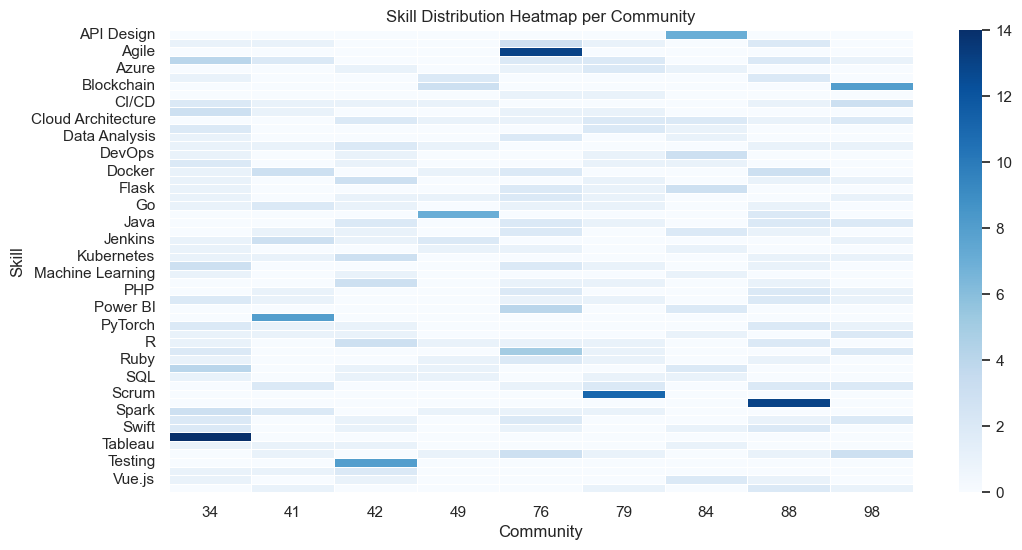

In [41]:
pivot_table = df.pivot(index="skill", columns="leiden_community", values="cnt").fillna(0)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="Blues", linewidths=0.5)
plt.xlabel("Community")
plt.ylabel("Skill")
plt.title("Skill Distribution Heatmap per Community")
plt.show()

In [42]:
G.drop()

graphName                                     person_similarity_projection
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                              100
relationshipCount                                                     2638
configuration            {'relationshipProjection': {'SIMILAR_SKILLSET'...
density                                                           0.266465
creationTime                           2025-03-12T16:16:27.264780666+00:00
modificationTime                       2025-03-12T16:16:27.264780666+00:00
schema                   {'graphProperties': {}, 'nodes': {'Person': {}...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'Person': {}...
Name: 0, dtype: object

## Semantic Similar skill

In [43]:
skills_df = gds.run_cypher(
    """
    MATCH (s:Skill)
    RETURN s.name AS skill
    """
)

In [44]:
skills_df.head(5)

,skill
0,API Design
1,AWS
2,Agile
3,Angular
4,Azure


### STOP STOP STOP - DO NOT PROCEED (YET)

-- Only to be run by instructor (or if you have your own api key). Skip the following two cells -- 

In [45]:
# skills_df['embedding'] = skills_df['description'].apply( lambda skill: embeddings.embed_documents([skill])[0])
# skills_df.head()

In [46]:
# gds.run_cypher('''
#     unwind $data as row
#     match (s:Skill{name: row.skill})
#     set s.embedding = row.embedding
#     ''',
#     params = { 'data': skills_df.to_dict(orient='records') }
# )

In [47]:
url = 'https://github.com/erikbijl/genai-workshop-amsterdam/raw/refs/heads/main/talent/data/skills_embeddings.csv'

In [48]:
skills_embeddings_df = pd.read_csv(url)

In [49]:
skills_embeddings_df.head()

,Skill,Description,Embedding
0,API Design,API Design is the process of creating applicat...,"[0.007902550511062145, -0.006266295909881592, ..."
1,AWS,Amazon Web Services (AWS) is a comprehensive a...,"[-0.0029347320087254047, -0.015877487137913704..."
2,Agile,Agile is a dynamic and flexible project manage...,"[-0.023693757131695747, -0.012672649696469307,..."
3,Angular,"Angular is a powerful, open-source web applica...","[0.013188531622290611, 0.029791485518217087, -..."
4,Azure,Azure is Microsoft's cloud computing platform ...,"[-0.004470727406442165, -0.024176467210054398,..."


In [50]:
skills_embeddings_df['Embedding'] = skills_embeddings_df['Embedding'].apply( lambda x: [ float(i) for i in x.strip("[]").split(", ")] )

In [51]:
skills_embeddings_df.head()

,Skill,Description,Embedding
0,API Design,API Design is the process of creating applicat...,"[0.007902550511062145, -0.006266295909881592, ..."
1,AWS,Amazon Web Services (AWS) is a comprehensive a...,"[-0.0029347320087254047, -0.015877487137913704..."
2,Agile,Agile is a dynamic and flexible project manage...,"[-0.023693757131695747, -0.012672649696469307,..."
3,Angular,"Angular is a powerful, open-source web applica...","[0.013188531622290611, 0.029791485518217087, -..."
4,Azure,Azure is Microsoft's cloud computing platform ...,"[-0.004470727406442165, -0.024176467210054398,..."


Length of an embedding

In [52]:
len(skills_embeddings_df['Embedding'].iloc[0])

1536

### Add Embeddings to the database

Add embeddings with the description to Skill nodes in database

In [53]:
for chunk in split_dataframe(skills_embeddings_df):
    records, summary, keys = driver.execute_query(
        """
        UNWIND $rows AS row
        MATCH (s:Skill{name: row.Skill})
        SET s.embedding = row.Embedding
        SET s.description = row.Description
        WITH s
        CALL db.create.setNodeVectorProperty(s, "embedding", s.embedding)
        RETURN COUNT(*) AS rows_processed
        """,
        database_=DATABASE,
        routing_=RoutingControl.WRITE,
        rows = chunk.to_dict('records')
    )

### Vectors for Semantic Meaning

In [54]:
driver.execute_query(
    """
    CREATE VECTOR INDEX `skill-embeddings` IF NOT EXISTS
    FOR (s:Skill) ON (s.embedding)
    OPTIONS {
        indexConfig: {
            `vector.dimensions`: 1536,
            `vector.similarity_function`: 'cosine'
        } 
    }
    """,
    database_=DATABASE,
    routing_=RoutingControl.WRITE
)      

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x16fe983d0>, keys=[])

In [55]:
indexes_result_df  = driver.execute_query(
    'SHOW INDEXES',
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)
indexes_result_df

,id,name,state,populationPercent,type,entityType,labelsOrTypes,properties,indexProvider,owningConstraint,lastRead,readCount
0,5,constraint_63bf11a1,ONLINE,100.0,RANGE,NODE,[Skill],[name],range-1.0,constraint_63bf11a1,None,NaN
1,3,constraint_d3bfd313,ONLINE,100.0,RANGE,NODE,[Person],[email],range-1.0,constraint_d3bfd313,None,NaN
2,0,index_343aff4e,ONLINE,100.0,LOOKUP,NODE,None,None,token-lookup-1.0,None,2025-03-12T16:12:24.285000000+00:00,13983.0
3,1,index_f7700477,ONLINE,100.0,LOOKUP,RELATIONSHIP,None,None,token-lookup-1.0,None,2025-03-12T14:44:35.371000000+00:00,69.0
4,4,skill-embeddings,POPULATING,0.0,VECTOR,NODE,[Skill],[embedding],vector-2.0,None,None,NaN


### Semantic Search

Take some Skill and find relevant other Skills: "Python", "Java", "Git", "CI/CD", "AWS", "Data Visualization", "Power BI", "R"". 

In [56]:
skill_search = "Python"

In [57]:
similar_skills_df  = driver.execute_query(
    """
    MATCH (s:Skill{name: $skill_search})
    CALL db.index.vector.queryNodes("skill-embeddings", 10, s.embedding) YIELD node, score
    WITH node as skill, score ORDER BY score DESC
    WHERE node.name <> s.name AND score > 0.9
    RETURN skill.name, score
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
    skill_search = skill_search

)
similar_skills_df

,skill.name,score
0,Ruby,0.929993
1,Java,0.924850
2,PHP,0.924561
3,Pandas,0.923492
4,C++,0.920074
5,Django,0.918076
6,JavaScript,0.917648
7,PyTorch,0.911591
8,Scala,0.908844


We can also find similarity from other terms than the skills in the database now. 

In [58]:
embeddings = OpenAIEmbeddings(model='text-embedding-ada-002')

Some suggestions to search for: 
- data visualizations and dashboards
- deployments
- API coding
- Machine Learning frameworks
- Cloud expertise

In [59]:
skill_search = "API coding"

In [60]:
driver.execute_query(
    '''
    CALL db.index.vector.queryNodes("skill-embeddings", 10, $query_vector) YIELD node, score
    WHERE score > 0.89
    RETURN node.name AS skill, score
    ''',
    database_ = DATABASE,
    routing_ = RoutingControl.READ,
    result_transformer_ = lambda r: r.to_df(),
    query_vector = embeddings.embed_query(skill_search)
)

,skill,score
0,API Design,0.910263
1,JavaScript,0.890549


Create relationship for similar sematic skills

In [61]:
driver.execute_query(
    """
    CALL apoc.periodic.iterate(
        "MATCH (skill1:Skill) RETURN skill1",
        "WITH skill1 
        CALL db.index.vector.queryNodes('skill-embeddings', 10, skill1.embedding) YIELD node, score
        WITH skill1, node as skill2, score ORDER BY score DESC
        WHERE skill1.name < skill2.name AND score > 0.92
        MERGE (skill1)-[s:SIMILAR_SEMANTIC]->(skill2)
        SET s.score = score   
        ",
        {batchSize: 1000}
    )
    """,
    database_=DATABASE,
    routing_=RoutingControl.WRITE,
    result_transformer_= lambda r: r.to_df()
)

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,1,54,0,54,0,0,0,{},"{'total': 1, 'errors': {}, 'committed': 1, 'fa...","{'total': 54, 'errors': {}, 'committed': 54, '...",False,{},"{'relationshipsDeleted': 0, 'relationshipsCrea..."


Let's look in the browser how these relationships look like. 

```MATCH p=()-[:SIMILAR_SEMANTIC]->() RETURN p```

What are similar skills in the database now? 

In [62]:
similar_skills_df  = driver.execute_query(
    """
    MATCH (s1:Skill)-[r:SIMILAR_SEMANTIC]-(s2:Skill)
    WHERE s1.name < s2.name
    RETURN s1.name AS skill1, r.score AS score, s2.name AS skill2
    ORDER BY score DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [63]:
similar_skills_df

,skill1,score,skill2
0,Data Visualization,0.951431,Tableau
1,Data Analysis,0.947662,Data Visualization
2,AWS,0.946609,Azure
3,Agile,0.942825,Scrum
4,CI/CD,0.941895,DevOps
5,ReactJS,0.939651,Vue.js
6,Power BI,0.937012,Tableau
7,Express.js,0.936569,Node.js
8,CI/CD,0.935562,Jenkins
9,Docker,0.935333,Kubernetes


## Now we can find more people with based on Semantic Similarity

Check the following in the browser:
```
MATCH (p1:Person {name: "John Garcia"})-[:KNOWS]->(s:Skill)
WITH p1, COLLECT(s.name) as skills_1
CALL (p1, p1){
  MATCH p=(p1)-[:KNOWS]->(s1:Skill)-[r:SIMILAR_SEMANTIC]-(s2:Skill)<-[:KNOWS]-(p2:Person)
  RETURN p
  UNION 
  MATCH (p1)-[r:SIMILAR_SKILLSET]->(p2:Person), p=(p2)-[:KNOWS]->(:Skill)
  RETURN p
}
RETURN p
```

The following persons give some interesting results: "Amelia Davis", "Victoria Thomas", "John Walker"

In [64]:
person_name_1 = "John Garcia"

In [65]:
similar_persons_df  = driver.execute_query(
    """
    MATCH (p1:Person {name: $person_name_1})-[:KNOWS]->(s:Skill)
    WITH p1, COLLECT(s.name) as skills_1
    CALL (p1){
      MATCH (p1)-[:KNOWS]->(s1:Skill)-[r:SIMILAR_SEMANTIC]-(s2:Skill)<-[:KNOWS]-(p2:Person)
      RETURN p1 as person_1, p2 as person_2, SUM(r.score) AS score
      UNION 
      MATCH (p1)-[r:SIMILAR_SKILLSET]->(p2:Person)
      RETURN p1 as person_1, p2 AS person_2, SUM(r.overlap) AS score
    }
    WITH person_1.name as person_1, skills_1, person_2, SUM(score) as score
    WHERE score >= 1
    MATCH (person_2)-[:KNOWS]->(s:Skill)
    RETURN person_1, skills_1,  person_2.name as person_2, COLLECT(s.name) as skills_2, score
    ORDER BY score DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
    person_name_1 = person_name_1
)

In [66]:
similar_persons_df

,person_1,skills_1,person_2,skills_2,score
0,John Garcia,"[Security, PyTorch, HTML5, Ruby, AWS]",Matthew Miller,"[TensorFlow, Ruby, AWS, ReactJS]",2.933380
1,John Garcia,"[Security, PyTorch, HTML5, Ruby, AWS]",Matthew Mitchell,"[R, HTML5, Blockchain, Cloud Architecture, Ruby]",2.931610
2,John Garcia,"[Security, PyTorch, HTML5, Ruby, AWS]",John Johnson,"[WordPress, TensorFlow, AWS, Project Managemen...",2.863373
3,John Garcia,"[Security, PyTorch, HTML5, Ruby, AWS]",Mia Nelson,"[Security, WordPress, Big Data, Swift, AWS]",2.000000
4,John Garcia,"[Security, PyTorch, HTML5, Ruby, AWS]",John Taylor,"[Pandas, Scrum, CSS3, Ruby, AWS]",2.000000
5,John Garcia,"[Security, PyTorch, HTML5, Ruby, AWS]",Matthew Moore,"[Security, TensorFlow, Spring Boot, Swift]",1.933380
6,John Garcia,"[Security, PyTorch, HTML5, Ruby, AWS]",Emily Thompson,"[Scrum, TensorFlow, Cloud Architecture, ReactJS]",1.864990
7,John Garcia,"[Security, PyTorch, HTML5, Ruby, AWS]",Ryan Young,"[WordPress, Blockchain, Cloud Architecture, Py...",1.861603
8,John Garcia,"[Security, PyTorch, HTML5, Ruby, AWS]",Thomas Nelson,"[Security, Pandas, Go]",1.000000
9,John Garcia,"[Security, PyTorch, HTML5, Ruby, AWS]",Richard Jackson,"[System Design, PyTorch, Express.js, DevOps]",1.000000


Calculate for all of them with score > 3

In [67]:
similar_persons_df  = driver.execute_query(
    """
    MATCH (p1:Person)-[:KNOWS]->(s:Skill)
    WITH p1, COLLECT(s.name) as skills_1
    CALL (p1, p1){
      MATCH (p1)-[:KNOWS]->(s1:Skill)-[r:SIMILAR_SEMANTIC]-(s2:Skill)<-[:KNOWS]-(p2:Person)
      RETURN p1 as person_1, p2 as person_2, SUM(r.score) AS score
      UNION 
      MATCH (p1)-[r:SIMILAR_SKILLSET]->(p2:Person)
      RETURN p1 as person_1, p2 AS person_2, SUM(r.overlap) AS score
    }
    WITH person_1.name as person_1, skills_1, person_2, SUM(score) as score
    WHERE score > 3
    MATCH (person_2)-[:KNOWS]->(s:Skill)
    RETURN person_1, skills_1,  person_2.name as person_2, COLLECT(s.name) as skills_2, score
    ORDER BY score DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [68]:
similar_persons_df

,person_1,skills_1,person_2,skills_2,score
0,Natalie Thompson,"[Angular, Jenkins, Spark, System Design, TypeS...",Ryan Jones,"[Angular, Spark, Jenkins, PHP, Project Managem...",3.930054
1,Joseph Martin,"[Agile, Java, Linux, Power BI, ReactJS]",Kevin Young,"[Linux, Agile, TensorFlow, ReactJS, C++]",3.925827
2,Andrew Martin,"[Cloud Architecture, Java, Node.js, R, Testing]",Oliver Bennett,"[R, JavaScript, Testing, Jenkins]",3.866257
3,Andrew Martin,"[Cloud Architecture, Java, Node.js, R, Testing]",James Anderson,"[Security, R, JavaScript, Node.js]",3.866257
4,Lucy Roberts,"[Angular, CI/CD, Data Visualization, Swift, Sy...",Natalie Thompson,"[System Design, Angular, Spark, TypeScript, Je...",3.865616
5,Amelia Phillips,"[Angular, Docker, Project Management, Scala, T...",Kevin Garcia,"[Agile, Angular, Docker, Power BI, Swift]",3.857498
6,Hannah Campbell,"[API Design, DevOps, JavaScript, Power BI, Vue...",Joseph Martin,"[Linux, Agile, Java, Power BI, ReactJS]",3.799652
7,Andrew Anderson,"[Data Visualization, DevOps, Java, Node.js, Te...",Ava White,"[CI/CD, Scala, Project Management, Data Visual...",3.794296
8,Andrew Anderson,"[Data Visualization, DevOps, Java, Node.js, Te...",Ryan Rodriguez,"[DevOps, JavaScript, Power BI]",3.792023
9,Andrew Anderson,"[Data Visualization, DevOps, Java, Node.js, Te...",Hannah Campbell,"[DevOps, API Design, JavaScript, Vue.js, Power...",3.792023
